### Metaplot of relative locations of bidirectionals within genes

In [56]:
library(data.table)
library(stringr)
library(ggplot2)
library(cowplot)
library(tidyverse)
library(pheatmap)
library(scales)

In [2]:
genome="hg38"
#genome="mm10"

In [3]:
## setting up visual parameters
ru_color = "gray65"
cowplot_theme = 24

In [4]:
# functions to save images
save_image_png <- function(x, filename, width=NULL, height=NULL) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   png(filename, width=width, height=height, units="in", res=100)
   grid::grid.newpage()
   grid::grid.draw(x)
   dev.off()
}
save_image_pdf <- function(x, filename, width=NULL, height=NULL) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x)
   dev.off()
}

## 00. Get overlaps of bidirectionals with RefSeq transcripts
The transcripts have a 300bp padding on both sides (to capture promoter regions)


In [7]:
## Hg38
# get padding of transcripts
transcripts <- fread("../data/processed_annotations/hg38/hg38_refseq_prim_chrom_transcripts.bed")
transcripts[1:2,]
# add 300bp padding on both sides
transcripts$V2 <- transcripts$V2 - 300
transcripts$V3 <- transcripts$V3 + 300

write.table(transcripts, 
            "../data/processed_annotations/hg38/hg38_refseq_prim_chrom_transcripts_300pad.bed", 
            col.names=FALSE, row.names=FALSE, quote=FALSE, sep="\t")

V1,V2,V3,V4,V5,V6
<chr>,<int>,<int>,<chr>,<chr>,<chr>
chr1,11873,14409,DDX11L1:NR_046018.2,.,+
chr1,14361,29370,WASH7P:NR_024540.1,.,-


In [8]:
## mm10
# get padding of transcripts
transcripts <- fread("../data/processed_annotations/mm10/mm10_refseq_prim_chrom_transcripts.bed")
transcripts[1:2,]
# add 300bp padding on both sides
transcripts$V2 <- transcripts$V2 - 300
transcripts$V3 <- transcripts$V3 + 300

write.table(transcripts, 
            "../data/processed_annotations/mm10/mm10_refseq_prim_chrom_transcripts_300pad.bed", 
            col.names=FALSE, row.names=FALSE, quote=FALSE, sep="\t")

V1,V2,V3,V4,V5,V6
<chr>,<int>,<int>,<chr>,<chr>,<chr>
chr1,3214481,3671498,Xkr4:NM_001011874.1,.,-
chr1,4119865,4360303,Rp1:NM_001370921.1,.,-


#### HUMAN (hg38)
GENE="../data/processed_annotations/hg38/hg38_refseq_prim_chrom_transcripts_300pad.bed"
BID="../data/processed_annotations/hg38/hg38_master_qc_gc_len_posneg_gene_filt_divconv_uniqueid_08-14-23.bed"

bedtools intersect -wo -a ${GENE} -b ${BID} > overlaps_hg38_trans_300pad_bid_12-3-23.bed

#### MOUSE (mm10)
GENE="../data/processed_annotations/mm10/mm10_refseq_prim_chrom_transcripts_300pad.bed"
BID="../data/processed_annotations/mm10/mm10_tfit_dreg_bidirectionals_uniqueid_08-27-23.bed"

bedtools intersect -wo -a ${GENE} -b ${BID} > overlaps_mm10_trans_300pad_bid_12-3-23.bed

## 0. Remove the TSS bidirectionals of smaller isoforms from overlapping the longer isoforms
We don't want to count TSS bidirectionals of smaller isoforms as intronic/exonic bidirectionals of the longer isoforms.

### A. Read in data
* Overlaps (variable = overlaps): 
    * results from bedtools intersect of the bidirectionals with RefSeq transcripts
* TSS Bidirectionals (variable = tss): 
    * produced from "Get_bid_TSSs.ipynb" notebook
* Long Isoforms (variable = long):
    * the longest transcript for each gene (based on RefSeq annotation)

In [57]:
rm(transcripts)

In [60]:
# read in the overlaps of all transcripts

hg38_overlaps <- fread("overlaps_hg38_trans_300pad_bid_12-3-23.bed")
dim(hg38_overlaps)
colnames(hg38_overlaps) <- c("Gene_chr", "Gene_start", "Gene_stop", "TranscriptID", "score", "strand", 
                      "Bid_chr", "Bid_start", "Bid_end", "BidID", 
                      "overlap")
# get the geneid
hg38_overlaps$GeneID <- str_split_fixed(hg38_overlaps$TranscriptID, ":", 2)[,1]
hg38_overlaps[1:2,]
# get list of TSS bidirectionals
hg38_tss <- fread("../data/processed_annotations/hg38/tss_bids_08-14-23.txt")
dim(hg38_tss)
hg38_tss[1:2,]


mm10_overlaps <- fread("overlaps_mm10_trans_300pad_bid_12-3-23.bed")
colnames(mm10_overlaps) <- c("Gene_chr", "Gene_start", "Gene_stop", "TranscriptID", "score", "strand", 
                      "Bid_chr", "Bid_start", "Bid_end", "BidID", 
                      "overlap")
dim(mm10_overlaps)
# get the geneid
mm10_overlaps$GeneID <- str_split_fixed(mm10_overlaps$TranscriptID, ":", 2)[,1]
mm10_overlaps[1:2,]
# get list of TSS bidirectionals
mm10_tss <- fread("../data/processed_annotations/mm10/mm10_tss_bids_08-27-23.txt")
dim(mm10_tss)
mm10_tss[1:2,]

[1] 2451579      11

Gene_chr,Gene_start,Gene_stop,TranscriptID,score,strand,Bid_chr,Bid_start,Bid_end,BidID,overlap,GeneID
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>
chr1,11573,14709,DDX11L1:NR_046018.2,.,+,chr1,12182,12456,"chr1-12182-12456-tfit,dreg",274,DDX11L1
chr1,11573,14709,DDX11L1:NR_046018.2,.,+,chr1,13264,13506,chr1-13264-13506-tfit,242,DDX11L1


[1] 62990    10

chr,TranscriptID,strand,GeneID,BidID,Frac_TSS_overlap,Frac_Bid_overlap,mu,TSS,MUDIFF
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>
chr1,MIR6859-1:NR_106918.1,-,MIR6859-1,chr1-17453-17621-tfit,0.28000,0.99408,17537,17436,101
chr1,LOC127239154:NR_182074.1,-,LOC127239154,chr1-297077-297529-dreg,0.54167,0.71744,297303,297504,201


[1] 844620     11

Gene_chr,Gene_start,Gene_stop,TranscriptID,score,strand,Bid_chr,Bid_start,Bid_end,BidID,overlap,GeneID
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>
chr1,3214181,3671798,Xkr4:NM_001011874.1,.,-,chr1,3230180,3230580,chr1-3230180-3230580-dreg,400,Xkr4
chr1,3214181,3671798,Xkr4:NM_001011874.1,.,-,chr1,3230650,3230880,chr1-3230650-3230880-dreg,230,Xkr4


[1] 33135    10

chr,TranscriptID,strand,GeneID,BidID,Frac_TSS_overlap,Frac_Bid_overlap,mu,TSS,MUDIFF
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>
chr1,Xkr4:NM_001011874.1,-,Xkr4,"chr1-3671408-3672036-tfit,dreg",0.65000,0.62003,3671722,3671498,224
chr1,Lypla1:NM_001355712.1,+,Lypla1,"chr1-4807665-4807931-tfit,dreg",0.44333,0.99625,4807798,4807822,24


### Separate overlaps of TSS bids 

In [61]:
hg38_overlaps[1:2,]
mm10_overlaps[1:2,]

Gene_chr,Gene_start,Gene_stop,TranscriptID,score,strand,Bid_chr,Bid_start,Bid_end,BidID,overlap,GeneID
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>
chr1,11573,14709,DDX11L1:NR_046018.2,.,+,chr1,12182,12456,"chr1-12182-12456-tfit,dreg",274,DDX11L1
chr1,11573,14709,DDX11L1:NR_046018.2,.,+,chr1,13264,13506,chr1-13264-13506-tfit,242,DDX11L1


Gene_chr,Gene_start,Gene_stop,TranscriptID,score,strand,Bid_chr,Bid_start,Bid_end,BidID,overlap,GeneID
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>
chr1,3214181,3671798,Xkr4:NM_001011874.1,.,-,chr1,3230180,3230580,chr1-3230180-3230580-dreg,400,Xkr4
chr1,3214181,3671798,Xkr4:NM_001011874.1,.,-,chr1,3230650,3230880,chr1-3230650-3230880-dreg,230,Xkr4


In [63]:
# separate overlaps into those invovling TSS bidirecitonals and those not
cat("hg38")
hg38_tss_overlaps <- hg38_overlaps[hg38_overlaps$BidID %in% hg38_tss$BidID,]
nrow(hg38_tss_overlaps)
hg38_nontss_overlaps <- hg38_overlaps[!hg38_overlaps$BidID %in% hg38_tss$BidID,]
nrow(hg38_nontss_overlaps)
nrow(hg38_tss_overlaps) + nrow(hg38_nontss_overlaps) == nrow(hg38_overlaps)
cat("\nmm10")
mm10_tss_overlaps <- mm10_overlaps[mm10_overlaps$BidID %in% mm10_tss$BidID,]
nrow(mm10_tss_overlaps)
mm10_nontss_overlaps <- mm10_overlaps[!mm10_overlaps$BidID %in% mm10_tss$BidID,]
nrow(mm10_nontss_overlaps)
nrow(mm10_tss_overlaps) + nrow(mm10_nontss_overlaps) == nrow(mm10_overlaps)

hg38

[1] 99386

[1] 2352193

[1] TRUE


mm10

[1] 43501

[1] 801119

[1] TRUE

### Of overlaps w/ TSS bids, only keep overlap if between Transcript & its identified TSS bid

In [66]:
## === FUNCTIONS
# function that will return TRUE if a TSS Bid is assigned to the transcript isoform provided
isIsoformsTSS_hg38 <- function(TSS_bid, transcript) {
    # get all transcripts that TSS_bid is assigned to
    assigned_transcripts <- hg38_tss[hg38_tss$BidID == TSS_bid,]$TranscriptID
    # return TRUE if transcript is in it
    transcript %in% assigned_transcripts
    }

isIsoformsTSS_mm10 <- function(TSS_bid, transcript) {
    # get all transcripts that TSS_bid is assigned to
    assigned_transcripts <- mm10_tss[mm10_tss$BidID == TSS_bid,]$TranscriptID
    # return TRUE if transcript is in it
    transcript %in% assigned_transcripts
    }
# test (only works for hg38 genome)
isIsoformsTSS("chr1-297077-297529-dreg", "LOC127239154:NR_182074.1") # TRUE
isIsoformsTSS("chr1-17453-17621-tfit", "LOC127239154:NR_182074.1") # FALSE
# list comprehension of tss overlaps
tss_overlaps[1:2,]
bool_IsoformsTSS <- map2(tss_overlaps[1:2,]$BidID, tss_overlaps[1:2,]$TranscriptID, isIsoformsTSS)
tss[tss$TranscriptID %in% tss_overlaps[1:2,]$TranscriptID,]
bool_IsoformsTSS # should be FALSE, TRUE based on above

[1] TRUE

[1] FALSE

Gene_chr,Gene_start,Gene_stop,TranscriptID,score,strand,Bid_chr,Bid_start,Bid_end,BidID,overlap,GeneID,bool_IsoformTSS
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<list>
chr1,14061,29670,WASH7P:NR_024540.1,.,-,chr1,17453,17621,chr1-17453-17621-tfit,168,WASH7P,FALSE
chr1,17068,17736,MIR6859-1:NR_106918.1,.,-,chr1,17453,17621,chr1-17453-17621-tfit,168,MIR6859-1,TRUE


chr,TranscriptID,strand,GeneID,BidID,Frac_TSS_overlap,Frac_Bid_overlap,mu,TSS,MUDIFF
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>
chr1,MIR6859-1:NR_106918.1,-,MIR6859-1,chr1-17453-17621-tfit,0.28,0.99408,17537,17436,101


[[1]]
[1] FALSE

[[2]]
[1] TRUE

In [67]:
# Run on full list
hg38_bool_IsoformsTSS <- map2(hg38_tss_overlaps$BidID, hg38_tss_overlaps$TranscriptID, isIsoformsTSS_hg38)
length(hg38_bool_IsoformsTSS)
# add as mark for tss_overlaps
hg38_tss_overlaps$bool_IsoformTSS <- hg38_bool_IsoformsTSS

# Run on full list
mm10_bool_IsoformsTSS <- map2(mm10_tss_overlaps$BidID, mm10_tss_overlaps$TranscriptID, isIsoformsTSS_mm10)
length(mm10_bool_IsoformsTSS)
# add as mark for tss_overlaps
mm10_tss_overlaps$bool_IsoformTSS <- mm10_bool_IsoformsTSS

[1] 99386

[1] 43501

In [68]:
# only keep TSS overlaps where the proper match is made (bool=TRUE)
cat("hg38")
nrow(hg38_tss_overlaps)
hg38_tss_overlaps2 <- hg38_tss_overlaps[hg38_tss_overlaps$bool_IsoformTSS == "TRUE",]
nrow(hg38_tss_overlaps2)
nrow(hg38_tss_overlaps) - nrow(hg38_tss_overlaps2)
(nrow(hg38_tss_overlaps) - nrow(hg38_tss_overlaps2))/nrow(hg38_overlaps)*100

cat("mm10")
nrow(mm10_tss_overlaps)
mm10_tss_overlaps2 <- mm10_tss_overlaps[mm10_tss_overlaps$bool_IsoformTSS == "TRUE",]
nrow(mm10_tss_overlaps2)
nrow(mm10_tss_overlaps) - nrow(mm10_tss_overlaps2)
(nrow(mm10_tss_overlaps) - nrow(mm10_tss_overlaps2))/nrow(mm10_overlaps)*100

hg38

[1] 99386

[1] 62990

[1] 36396

[1] 1.484594

mm10

[1] 43501

[1] 33135

[1] 10366

[1] 1.227297

In [69]:
# Recombine the filtered overlaps 
cat("hg38")
orig <- nrow(hg38_overlaps)
orig
hg38_nontss_overlaps$bool_IsoformTSS <- rep(NA, nrow(hg38_nontss_overlaps))
hg38_overlaps <- rbind(hg38_tss_overlaps2[], hg38_nontss_overlaps)
nrow(hg38_overlaps)

cat("mm10")
orig <- nrow(mm10_overlaps)
orig
mm10_nontss_overlaps$bool_IsoformTSS <- rep(NA, nrow(mm10_nontss_overlaps))
mm10_overlaps <- rbind(mm10_tss_overlaps2[], mm10_nontss_overlaps)
nrow(mm10_overlaps)

hg38

[1] 2451579

[1] 2415183

mm10

[1] 844620

[1] 834254

## 1. Normalize bidirectional locations to percentage location of gene

### Test of pipeline to get the percentile based coordinates of bidirectionals within genes

In [43]:
# practice df to make sure I'm doing what I think I'm doing
test <- data.frame(data.table("chr"=c(1,1,1,1,1), 
                                  "Gene_start"=c(90, 90, 90, 90, 90), 
                                  "Gene_stop"=c(500, 500, 500, 500, 500), 
                                  "TranscriptID"=c("Gene+", "Gene+", "Gene-", "Gene-", "Gene-"), 
                                  "strand"=c("+", "+", "-", "-", "-"), 
                                  "Bid_start"=c(80, 490, 80, 490, 70), "Bid_end"=c(100, 510, 100, 510, 90)))

# == Get the length (Ref gene end) & size factors of genes
test$Ref_Gene_end <- test$Gene_stop - test$Gene_start
test$sizefactor <- 100/(test$Ref_Gene_end+1)

# == Get the coordinates of bidirectionals in reference to TSS of gene
pos_test <- test[test$strand == "+",]
neg_test <- test[test$strand == "-",]

pos_test$Ref_Bid_start = pos_test$Bid_start - pos_test$Gene_start
pos_test$Ref_Bid_end = pos_test$Bid_end - pos_test$Gene_start
pos_test$Ref_Bid_mid = (pos_test$Ref_Bid_start + pos_test$Ref_Bid_end)/2

# Negative (Bid side closest to gene start will be end so make start end & opp)
neg_test$Ref_Bid_end = neg_test$Gene_stop - neg_test$Bid_start 
neg_test$Ref_Bid_start = neg_test$Gene_stop - neg_test$Bid_end 
neg_test$Ref_Bid_mid = (neg_test$Ref_Bid_start + neg_test$Ref_Bid_end)/2

# == Get the coordinates of bidirectionals as percentiles of gene
pos_test$Norm_Bid_start = round(pos_test$Ref_Bid_start*pos_test$sizefactor)
pos_test$Norm_Bid_end = round(pos_test$Ref_Bid_end*pos_test$sizefactor)
pos_test$Norm_Bid_mid = round(pos_test$Ref_Bid_mid*pos_test$sizefactor)

neg_test$Norm_Bid_start = round(neg_test$Ref_Bid_start*neg_test$sizefactor)
neg_test$Norm_Bid_end = round(neg_test$Ref_Bid_end*neg_test$sizefactor)
neg_test$Norm_Bid_mid = round(neg_test$Ref_Bid_mid*neg_test$sizefactor)

pos_test
neg_test

,chr,Gene_start,Gene_stop,TranscriptID,strand,Bid_start,Bid_end,Ref_Gene_end,sizefactor,Ref_Bid_start,Ref_Bid_end,Ref_Bid_mid,Norm_Bid_start,Norm_Bid_end,Norm_Bid_mid
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,90,500,Gene+,+,80,100,410,0.243309,-10,10,0,-2,2,0
2,1,90,500,Gene+,+,490,510,410,0.243309,400,420,410,97,102,100


,chr,Gene_start,Gene_stop,TranscriptID,strand,Bid_start,Bid_end,Ref_Gene_end,sizefactor,Ref_Bid_end,Ref_Bid_start,Ref_Bid_mid,Norm_Bid_start,Norm_Bid_end,Norm_Bid_mid
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,1,90,500,Gene-,-,80,100,410,0.243309,420,400,410,97,102,100
4,1,90,500,Gene-,-,490,510,410,0.243309,10,-10,0,-2,2,0
5,1,90,500,Gene-,-,70,90,410,0.243309,430,410,420,100,105,102


### A. Get the Length (Reference end) & sizefactor for each gene

In [70]:
# Change the 300 padding back to the original start (TSS) & stop (PAS)
hg38_overlaps$Gene_start <- hg38_overlaps$Gene_start + 300
hg38_overlaps$Gene_stop <- hg38_overlaps$Gene_stop - 300

mm10_overlaps$Gene_start <- mm10_overlaps$Gene_start + 300
mm10_overlaps$Gene_stop <- mm10_overlaps$Gene_stop - 300

In [71]:
# get the length of the gene as the standardized end
hg38_overlaps$Ref_Gene_end <- hg38_overlaps$Gene_stop - hg38_overlaps$Gene_start
mm10_overlaps$Ref_Gene_end <- mm10_overlaps$Gene_stop - mm10_overlaps$Gene_start
# create a size factor
hg38_overlaps$sizefactor <- 100/(hg38_overlaps$Ref_Gene_end+1)
hg38_overlaps[1:2,]
mm10_overlaps$sizefactor <- 100/(mm10_overlaps$Ref_Gene_end+1)
mm10_overlaps[1:2,]

Gene_chr,Gene_start,Gene_stop,TranscriptID,score,strand,Bid_chr,Bid_start,Bid_end,BidID,overlap,GeneID,bool_IsoformTSS,Ref_Gene_end,sizefactor
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<list>,<dbl>,<dbl>
chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,chr1,17453,17621,chr1-17453-17621-tfit,168,MIR6859-1,TRUE,68,1.44927536
chr1,34610,36081,FAM138A:NR_026818.1,.,-,chr1,36343,36775,chr1-36343-36775-dreg,38,FAM138A,TRUE,1471,0.06793478


Gene_chr,Gene_start,Gene_stop,TranscriptID,score,strand,Bid_chr,Bid_start,Bid_end,BidID,overlap,GeneID,bool_IsoformTSS,Ref_Gene_end,sizefactor
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<list>,<dbl>,<dbl>
chr1,3214481,3671498,Xkr4:NM_001011874.1,.,-,chr1,3671408,3672036,"chr1-3671408-3672036-tfit,dreg",390,Xkr4,TRUE,457017,0.0002188098
chr1,4490927,4497354,Sox17:NM_011441.5,.,-,chr1,4497322,4497640,"chr1-4497322-4497640-tfit,dreg",318,Sox17,TRUE,6427,0.0155569384


### B. Change the bidirectional locations in reference to TSS of gene

In [72]:
# split the posiitiive and negative genes
hg38_pos_overlaps <- hg38_overlaps[hg38_overlaps$strand == "+",]
hg38_neg_overlaps <- hg38_overlaps[hg38_overlaps$strand == "-",]
mm10_pos_overlaps <- mm10_overlaps[mm10_overlaps$strand == "+",]
mm10_neg_overlaps <- mm10_overlaps[mm10_overlaps$strand == "-",]

In [73]:
## HG38
# Change the bid locations in reference to start
#   Pos strand gene Gene start = Gene_start (leftmost)
hg38_pos_overlaps$Ref_Bid_start = hg38_pos_overlaps$Bid_start - hg38_pos_overlaps$Gene_start
hg38_pos_overlaps$Ref_Bid_end = hg38_pos_overlaps$Bid_end - hg38_pos_overlaps$Gene_start
hg38_pos_overlaps$Ref_Bid_mid = (hg38_pos_overlaps$Ref_Bid_start + hg38_pos_overlaps$Ref_Bid_end)/2
#   Neg strand gene Gene start = Gene_stop (rightmost)
#   To ensure Bids are still closest to start to farthest oriented: (Bid side closest to gene start will be end so make start end & opp)
hg38_neg_overlaps$Ref_Bid_end = hg38_neg_overlaps$Gene_stop - hg38_neg_overlaps$Bid_start 
hg38_neg_overlaps$Ref_Bid_start = hg38_neg_overlaps$Gene_stop - hg38_neg_overlaps$Bid_end 
hg38_neg_overlaps$Ref_Bid_mid = (hg38_neg_overlaps$Ref_Bid_start + hg38_neg_overlaps$Ref_Bid_end)/2

## mm10
# Change the bid locations in reference to start
#   Pos strand gene Gene start = Gene_start (leftmost)
mm10_pos_overlaps$Ref_Bid_start = mm10_pos_overlaps$Bid_start - mm10_pos_overlaps$Gene_start
mm10_pos_overlaps$Ref_Bid_end = mm10_pos_overlaps$Bid_end - mm10_pos_overlaps$Gene_start
mm10_pos_overlaps$Ref_Bid_mid = (mm10_pos_overlaps$Ref_Bid_start + mm10_pos_overlaps$Ref_Bid_end)/2
#   Neg strand gene Gene start = Gene_stop (rightmost)
#   To ensure Bids are still closest to start to farthest oriented: (Bid side closest to gene start will be end so make start end & opp)
mm10_neg_overlaps$Ref_Bid_end = mm10_neg_overlaps$Gene_stop - mm10_neg_overlaps$Bid_start 
mm10_neg_overlaps$Ref_Bid_start = mm10_neg_overlaps$Gene_stop - mm10_neg_overlaps$Bid_end 
mm10_neg_overlaps$Ref_Bid_mid = (mm10_neg_overlaps$Ref_Bid_start + mm10_neg_overlaps$Ref_Bid_end)/2

### C. Standardize the bid locations as percentiles of the total gene (start & stop)

In [74]:
# multiply all positions by the size factor
hg38_pos_overlaps$Norm_Bid_start = round(hg38_pos_overlaps$Ref_Bid_start*hg38_pos_overlaps$sizefactor)
hg38_pos_overlaps$Norm_Bid_end = round(hg38_pos_overlaps$Ref_Bid_end*hg38_pos_overlaps$sizefactor)
hg38_pos_overlaps$Norm_Bid_mid = round(hg38_pos_overlaps$Ref_Bid_mid*hg38_pos_overlaps$sizefactor)

hg38_neg_overlaps$Norm_Bid_start = round(hg38_neg_overlaps$Ref_Bid_start*hg38_neg_overlaps$sizefactor)
hg38_neg_overlaps$Norm_Bid_end = round(hg38_neg_overlaps$Ref_Bid_end*hg38_neg_overlaps$sizefactor)
hg38_neg_overlaps$Norm_Bid_mid = round(hg38_neg_overlaps$Ref_Bid_mid*hg38_neg_overlaps$sizefactor)

# multiply all positions by the size factor
mm10_pos_overlaps$Norm_Bid_start = round(mm10_pos_overlaps$Ref_Bid_start*mm10_pos_overlaps$sizefactor)
mm10_pos_overlaps$Norm_Bid_end = round(mm10_pos_overlaps$Ref_Bid_end*mm10_pos_overlaps$sizefactor)
mm10_pos_overlaps$Norm_Bid_mid = round(mm10_pos_overlaps$Ref_Bid_mid*mm10_pos_overlaps$sizefactor)

mm10_neg_overlaps$Norm_Bid_start = round(mm10_neg_overlaps$Ref_Bid_start*mm10_neg_overlaps$sizefactor)
mm10_neg_overlaps$Norm_Bid_end = round(mm10_neg_overlaps$Ref_Bid_end*mm10_neg_overlaps$sizefactor)
mm10_neg_overlaps$Norm_Bid_mid = round(mm10_neg_overlaps$Ref_Bid_mid*mm10_neg_overlaps$sizefactor)

In [75]:
# combine the pos & neg overlaps again
hg38_overlaps <- rbind(hg38_pos_overlaps, hg38_neg_overlaps)
dim(hg38_overlaps)
hg38_overlaps[1:2,]

# combine the pos & neg overlaps again
mm10_overlaps <- rbind(mm10_pos_overlaps, mm10_neg_overlaps)
dim(mm10_overlaps)
mm10_overlaps[1:2,]

[1] 2415183      21

Gene_chr,Gene_start,Gene_stop,TranscriptID,score,strand,Bid_chr,Bid_start,Bid_end,BidID,⋯,GeneID,bool_IsoformTSS,Ref_Gene_end,sizefactor,Ref_Bid_start,Ref_Bid_end,Ref_Bid_mid,Norm_Bid_start,Norm_Bid_end,Norm_Bid_mid
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<chr>,<list>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1,182387,184878,DDX11L17:NR_148357.1,.,+,chr1,181984,182180,"chr1-181984-182180-tfit,dreg",⋯,DDX11L17,TRUE,2491,0.04012841,-403,-207,-305,-16,-8,-12
chr1,817370,819834,FAM87B:NR_103536.1,.,+,chr1,817274,817686,chr1-817274-817686-dreg,⋯,FAM87B,TRUE,2464,0.04056795,-96,316,110,-4,13,4


[1] 834254     21

Gene_chr,Gene_start,Gene_stop,TranscriptID,score,strand,Bid_chr,Bid_start,Bid_end,BidID,⋯,GeneID,bool_IsoformTSS,Ref_Gene_end,sizefactor,Ref_Bid_start,Ref_Bid_end,Ref_Bid_mid,Norm_Bid_start,Norm_Bid_end,Norm_Bid_mid
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<chr>,<list>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1,4807822,4846735,Lypla1:NM_001355712.1,.,+,chr1,4807665,4807931,"chr1-4807665-4807931-tfit,dreg",⋯,Lypla1,TRUE,38913,0.002569769,-157,109,-24,0,0,0
chr1,4807822,4846735,Lypla1:NM_008866.3,.,+,chr1,4807665,4807931,"chr1-4807665-4807931-tfit,dreg",⋯,Lypla1,TRUE,38913,0.002569769,-157,109,-24,0,0,0


## 2. Graph the Standardized Locations
* Note about Warning messages: The warning messages are because I cut off certain x values as evident by the fact that there are no NA or infinite values in what is being graphed

In [76]:
any(is.na(hg38_overlaps$Norm_Bid_start))
any(is.na(hg38_overlaps$Norm_Bid_end))
any(is.na(hg38_overlaps$Norm_Bid_mid))
any(is.infinite(hg38_overlaps$Norm_Bid_start))
any(is.infinite(hg38_overlaps$Norm_Bid_end))
any(is.infinite(hg38_overlaps$Norm_Bid_mid))

any(is.na(mm10_overlaps$Norm_Bid_start))
any(is.na(mm10_overlaps$Norm_Bid_end))
any(is.na(mm10_overlaps$Norm_Bid_mid))
any(is.infinite(mm10_overlaps$Norm_Bid_start))
any(is.infinite(mm10_overlaps$Norm_Bid_end))
any(is.infinite(mm10_overlaps$Norm_Bid_mid))

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

#### Summary Statistics

In [86]:
cat("hg38 # & % in promoter region (600bp window around TSS)")
dim(hg38_overlaps[hg38_overlaps$Ref_Bid_start < 300,])
dim(hg38_overlaps)
dim(hg38_overlaps[hg38_overlaps$Ref_Bid_start < 300,])/dim(hg38_overlaps)*100
cat("\nmm10 # & % in promoter region (600bp window around TSS)")
dim(mm10_overlaps[mm10_overlaps$Ref_Bid_start < 300,])
dim(mm10_overlaps)
dim(mm10_overlaps[mm10_overlaps$Ref_Bid_start < 300,])/dim(mm10_overlaps)*100

hg38 # & % in promoter region (600bp window around TSS)

[1] 77000    21

[1] 2415183      21

[1]   3.188164 100.000000


mm10 # & % in promoter region (600bp window around TSS)

[1] 41034    21

[1] 834254     21

[1]   4.918646 100.000000

### Comparing the full set of bidirectionals in 300bp windows on both sides to only those within 10% of the annotated TSS and PAS of the gene

hg38

Warning message:
“Removed 3594 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 3056 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2742 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


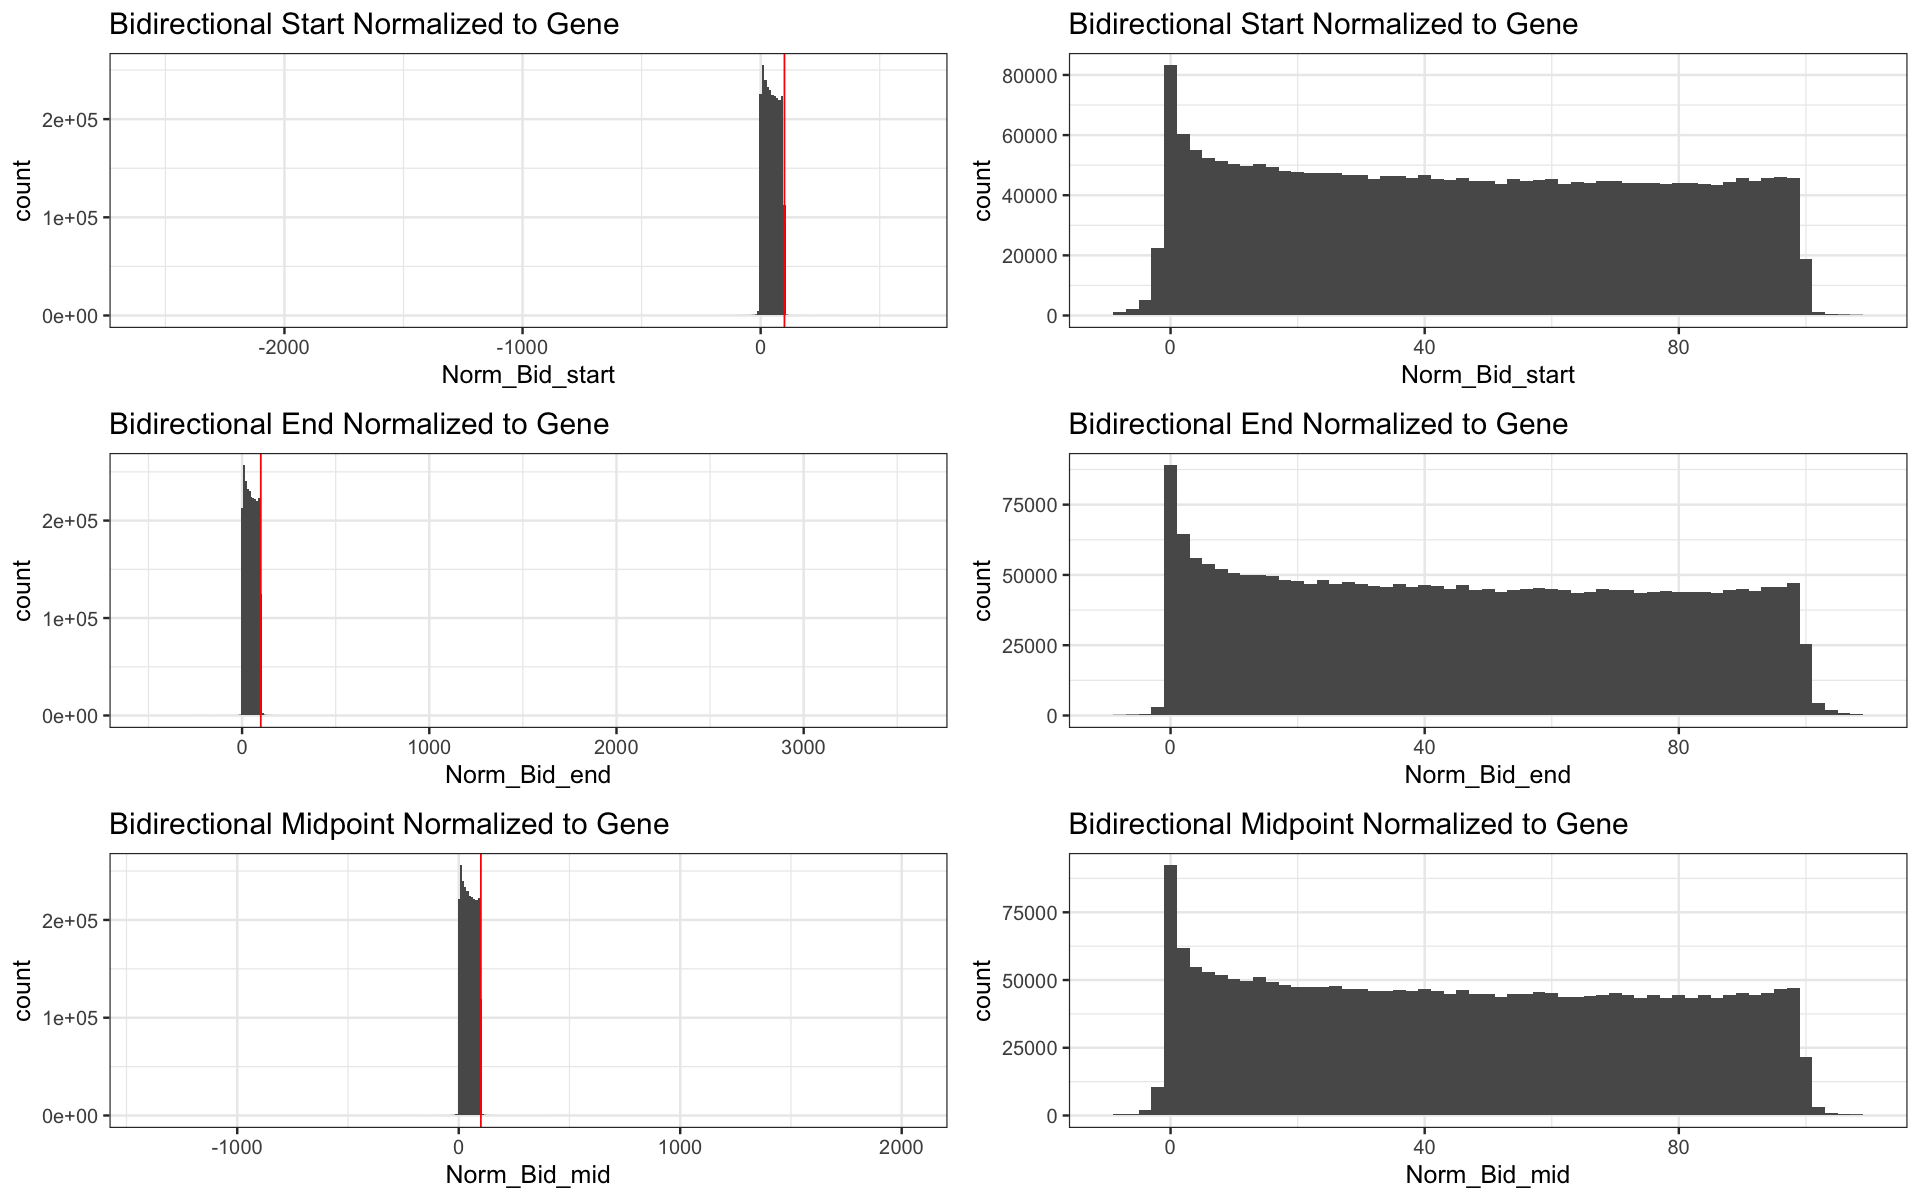

In [78]:
# Grpah the locations
cat("hg38")
p1 <- ggplot(hg38_overlaps, aes(x=Norm_Bid_start)) + geom_histogram(binwidth=10) + theme_bw(base_size=15) +
ggtitle("Bidirectional Start Normalized to Gene")+ geom_vline(xintercept=100, color="red")
p1b <- ggplot(hg38_overlaps, aes(x=Norm_Bid_start)) + geom_histogram(binwidth=2) + theme_bw(base_size=15) +
ggtitle("Bidirectional Start Normalized to Gene") + xlim(-10, 110)
p2 <- ggplot(hg38_overlaps, aes(x=Norm_Bid_end)) + geom_histogram(binwidth=10) + theme_bw(base_size=15) +
ggtitle("Bidirectional End Normalized to Gene")+ geom_vline(xintercept=100, color="red")
p2b <- ggplot(hg38_overlaps, aes(x=Norm_Bid_end)) + geom_histogram(binwidth=2) + theme_bw(base_size=15) +
ggtitle("Bidirectional End Normalized to Gene") + xlim(-10, 110)
p3 <- ggplot(hg38_overlaps, aes(x=Norm_Bid_mid)) + geom_histogram(binwidth=10) + theme_bw(base_size=15) +
ggtitle("Bidirectional Midpoint Normalized to Gene") + geom_vline(xintercept=100, color="red")
p3b <- ggplot(hg38_overlaps, aes(x=Norm_Bid_mid)) + geom_histogram(binwidth=2) + theme_bw(base_size=15) +
ggtitle("Bidirectional Midpoint Normalized to Gene") + xlim(-10, 110)
options(repr.plot.height = 10, repr.plot.width =16 )
plot_grid(p1, p1b, p2, p2b, p3, p3b,  nrow=3)

mm10

Warning message:
“Removed 2410 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2216 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 1818 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


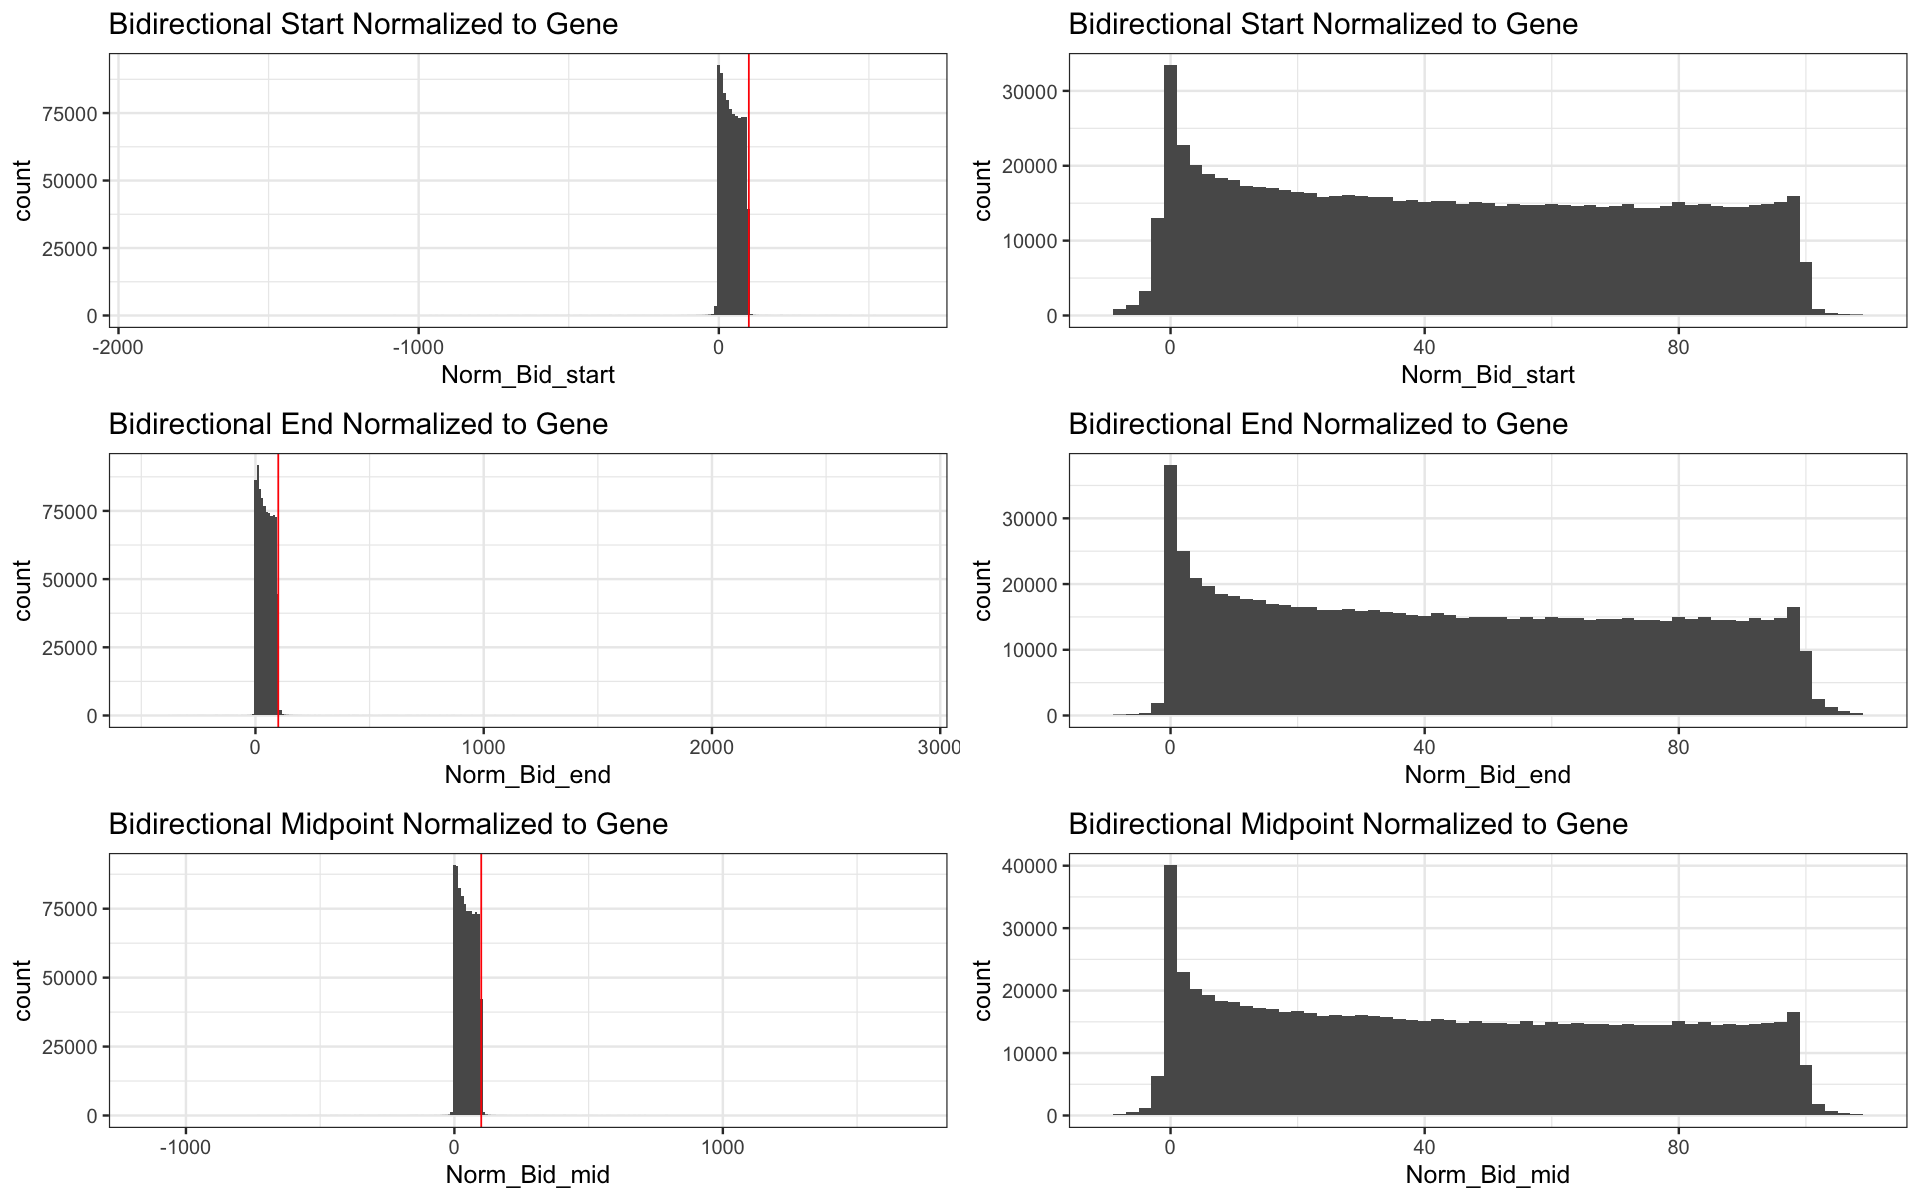

In [79]:
# Grpah the locations
cat("mm10")
p1 <- ggplot(mm10_overlaps, aes(x=Norm_Bid_start)) + geom_histogram(binwidth=10) + theme_bw(base_size=15) +
ggtitle("Bidirectional Start Normalized to Gene")+ geom_vline(xintercept=100, color="red")
p1b <- ggplot(mm10_overlaps, aes(x=Norm_Bid_start)) + geom_histogram(binwidth=2) + theme_bw(base_size=15) +
ggtitle("Bidirectional Start Normalized to Gene") + xlim(-10, 110)
p2 <- ggplot(mm10_overlaps, aes(x=Norm_Bid_end)) + geom_histogram(binwidth=10) + theme_bw(base_size=15) +
ggtitle("Bidirectional End Normalized to Gene")+ geom_vline(xintercept=100, color="red")
p2b <- ggplot(mm10_overlaps, aes(x=Norm_Bid_end)) + geom_histogram(binwidth=2) + theme_bw(base_size=15) +
ggtitle("Bidirectional End Normalized to Gene") + xlim(-10, 110)
p3 <- ggplot(mm10_overlaps, aes(x=Norm_Bid_mid)) + geom_histogram(binwidth=10) + theme_bw(base_size=15) +
ggtitle("Bidirectional Midpoint Normalized to Gene") + geom_vline(xintercept=100, color="red")
p3b <- ggplot(mm10_overlaps, aes(x=Norm_Bid_mid)) + geom_histogram(binwidth=2) + theme_bw(base_size=15) +
ggtitle("Bidirectional Midpoint Normalized to Gene") + xlim(-10, 110)
options(repr.plot.height = 10, repr.plot.width =16 )
plot_grid(p1, p1b, p2, p2b, p3, p3b,  nrow=3)

[1] 0

[1] 100

Warning message:
“Removed 1707 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2742 rows containing non-finite values (`stat_density()`).”


pdf 
  2

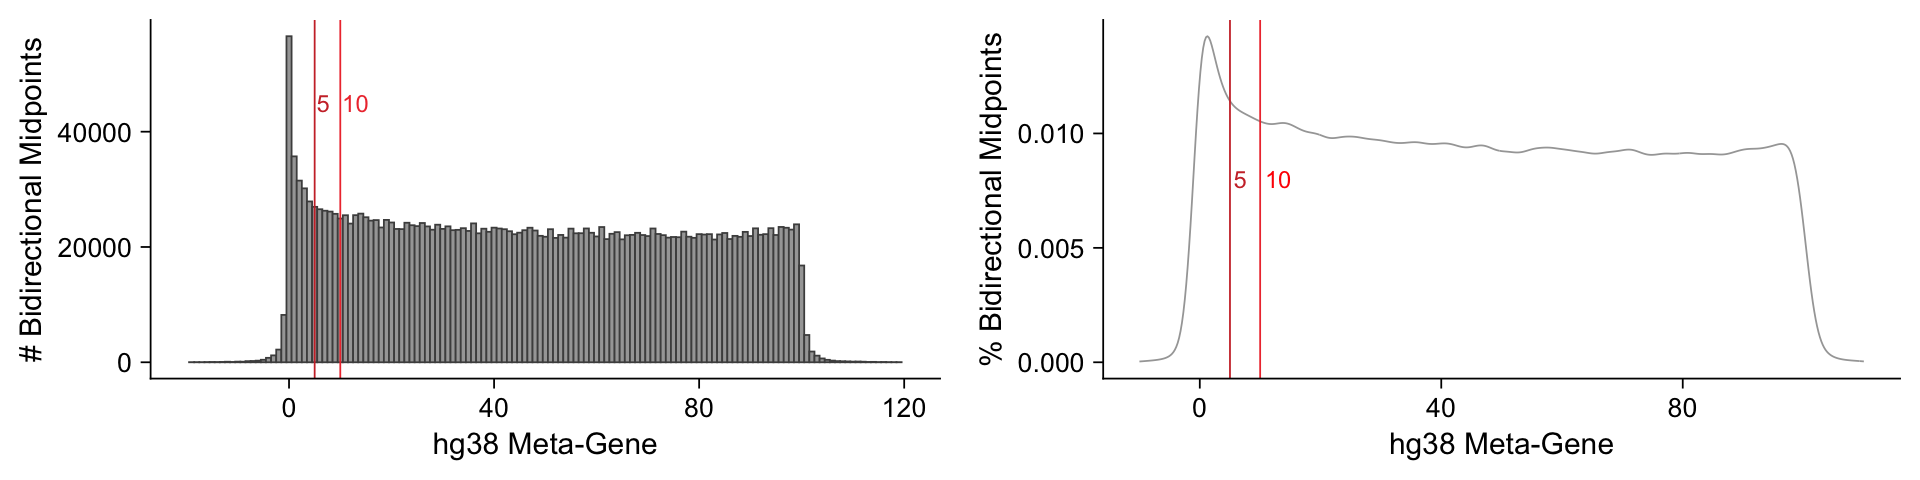

In [80]:
color5 = "brown3"
color10 = "brown2"
p1 <- ggplot(hg38_overlaps, aes(x=Norm_Bid_mid)) + geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
#ggtitle("                                               Bidirectional Midpoint Normalized to Gene (-10% to 110%)") + 
xlim(-20, 120) + labs(x="hg38 Meta-Gene",y="# Bidirectional Midpoints") +
geom_vline(xintercept=5, color=color5) + annotate("text", x=6.7, y=45000, label="5", color=color5, size=5) + 
geom_vline(xintercept=10, color=color10) + annotate("text", x=13, y=45000, label="10", color=color10, size=5) + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 28), 
      axis.title = element_text(size = 18), 
      axis.text = element_text(size = 16))
hg38_use <- hg38_overlaps[hg38_overlaps$Norm_Bid_mid > -0.5 & hg38_overlaps$Norm_Bid_mid < 100.5,]
min(hg38_use$Norm_Bid_mid)
max(hg38_use$Norm_Bid_mid)


p3 <- ggplot(hg38_overlaps, aes(x=Norm_Bid_mid)) + xlim(-10, 110) +
geom_density(color=ru_color) + theme_cowplot(cowplot_theme) + 
geom_vline(xintercept=5, color=color5) + annotate("text", x=6.7, y=0.008, label="5", color=color5, size=5) + 
geom_vline(xintercept=10, color=color10) + annotate("text", x=13, y=0.008, label="10", color="red", size=5) +
labs(x="hg38 Meta-Gene", y="% Bidirectional Midpoints") + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 28), 
      axis.title = element_text(size = 18), 
      axis.text = element_text(size = 16))

options(repr.plot.height = 4, repr.plot.width =16 )
save <- plot_grid(p1, p3)
save
save_image_png(save, paste0("./figures/", "hg38_300pad_Norm_Bid_mid_histogram.png"), width=16, height=4)

[1] 0

[1] 100

Warning message:
“Removed 1103 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 1818 rows containing non-finite values (`stat_density()`).”


pdf 
  2

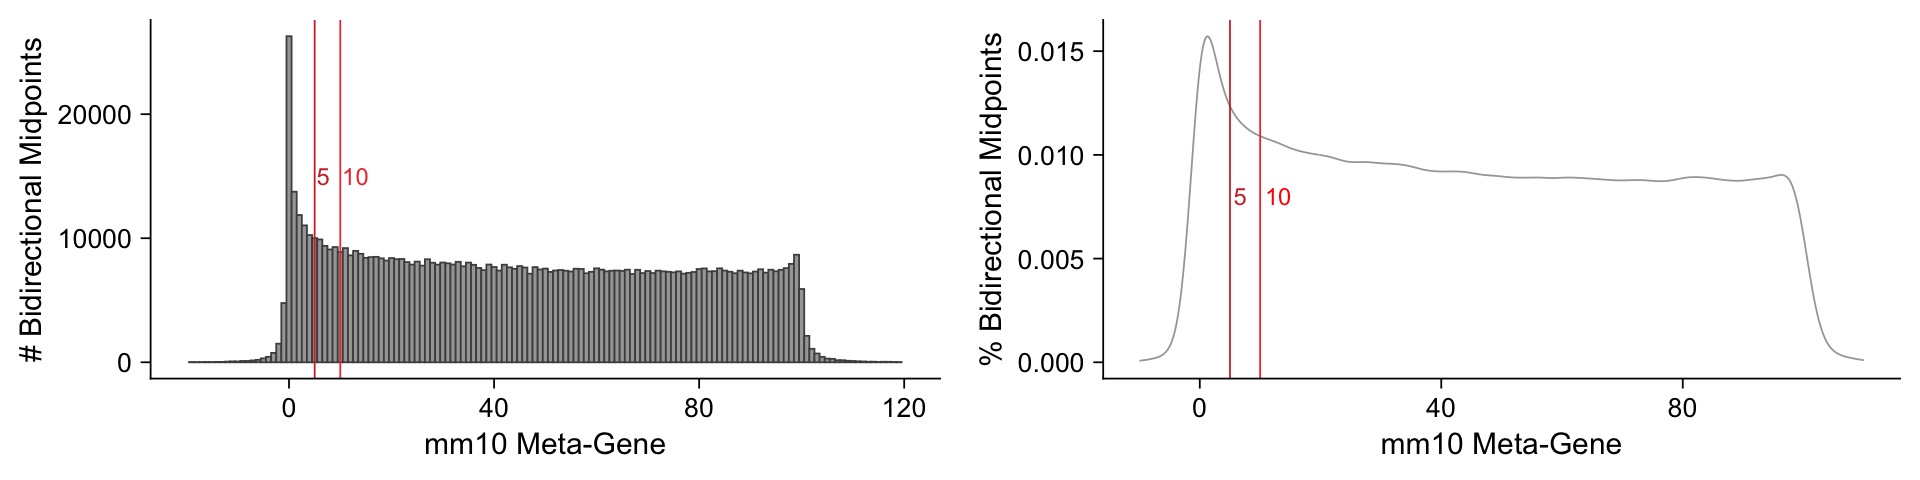

In [82]:
color5 = "brown3"
color10 = "brown2"
p1 <- ggplot(mm10_overlaps, aes(x=Norm_Bid_mid)) + geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
#ggtitle("                                               Bidirectional Midpoint Normalized to Gene (-10% to 110%)") + 
xlim(-20, 120) + labs(x="mm10 Meta-Gene",y="# Bidirectional Midpoints") +
geom_vline(xintercept=5, color=color5) + annotate("text", x=6.7, y=15000, label="5", color=color5, size=5) + 
geom_vline(xintercept=10, color=color10) + annotate("text", x=13, y=15000, label="10", color=color10, size=5) + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 28), 
      axis.title = element_text(size = 18), 
      axis.text = element_text(size = 16))
mm10_use <- mm10_overlaps[mm10_overlaps$Norm_Bid_mid > -0.5 & mm10_overlaps$Norm_Bid_mid < 100.5,]
min(mm10_use$Norm_Bid_mid)
max(mm10_use$Norm_Bid_mid)


p3 <- ggplot(mm10_overlaps, aes(x=Norm_Bid_mid)) + xlim(-10, 110) +
geom_density(color=ru_color) + theme_cowplot(cowplot_theme) + 
geom_vline(xintercept=5, color=color5) + annotate("text", x=6.7, y=0.008, label="5", color=color5, size=5) + 
geom_vline(xintercept=10, color=color10) + annotate("text", x=13, y=0.008, label="10", color="red", size=5) +
labs(x="mm10 Meta-Gene", y="% Bidirectional Midpoints") + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 28), 
      axis.title = element_text(size = 18), 
      axis.text = element_text(size = 16))

options(repr.plot.height = 4, repr.plot.width =16 )
save <- plot_grid(p1, p3)
save
save_image_png(save, paste0("./figures/", "mm10_300pad_Norm_Bid_mid_histogram.png"), width=16, height=4)

Gene_chr,Gene_start,Gene_stop,TranscriptID,score,strand,Bid_chr,Bid_start,Bid_end,BidID,⋯,GeneID,bool_IsoformTSS,Ref_Gene_end,sizefactor,Ref_Bid_start,Ref_Bid_end,Ref_Bid_mid,Norm_Bid_start,Norm_Bid_end,Norm_Bid_mid
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<chr>,<list>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1,182387,184878,DDX11L17:NR_148357.1,.,+,chr1,181984,182180,"chr1-181984-182180-tfit,dreg",⋯,DDX11L17,TRUE,2491,0.04012841,-403,-207,-305,-16,-8,-12
chr1,817370,819834,FAM87B:NR_103536.1,.,+,chr1,817274,817686,chr1-817274-817686-dreg,⋯,FAM87B,TRUE,2464,0.04056795,-96,316,110,-4,13,4


hg38 # Genes 23752  # Transcripts 80806
mm10 # Genes 21590  # Transcripts 40652

Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


pdf 
  2

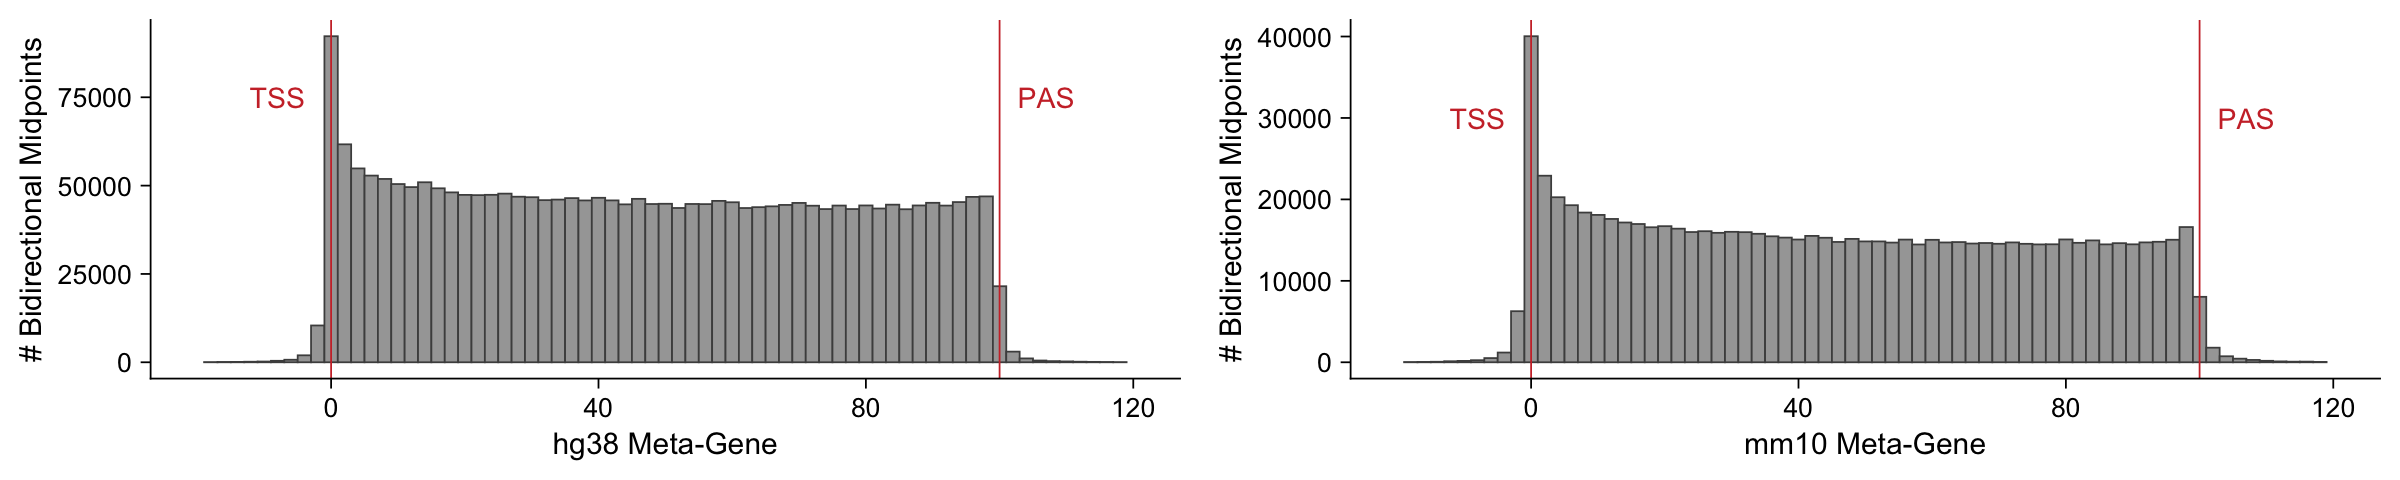

In [109]:
color5 = "brown2"
color10 = "brown3"
use = hg38_overlaps[hg38_overlaps$Norm_Bid_mid >= -20 & hg38_overlaps$Norm_Bid_mid <= 120,]
cat("hg38 # Genes", length(unique(use$GeneID)), " # Transcripts", length(unique(use$TranscriptID)))

p1 <- ggplot(use, aes(x=Norm_Bid_mid)) + geom_histogram(binwidth=2, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
#ggtitle("                                               Bidirectional Midpoint Normalized to Gene (-10% to 110%)") + 
xlim(-20, 120) + labs(x="hg38 Meta-Gene",y="# Bidirectional Midpoints") +
geom_vline(xintercept=0, color=color10) + annotate("text", x=-8, y=75000, label="TSS",  size=6, color=color10) + 
geom_vline(xintercept=100, color=color10) + annotate("text", x=107, y=75000, label="PAS", size=6, color=color10) + 
#geom_vline(xintercept=5, color=color5) + annotate("text", x=6.7, y=60000, label="5", color=color5, size=5) + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 28), 
      axis.title = element_text(size = 18), 
      axis.text = element_text(size = 16))

use = mm10_overlaps[mm10_overlaps$Norm_Bid_mid >= -20 & mm10_overlaps$Norm_Bid_mid <= 120,]
cat("\nmm10 # Genes", length(unique(use$GeneID)), " # Transcripts", length(unique(use$TranscriptID)))
p2 <- ggplot(use, aes(x=Norm_Bid_mid)) + geom_histogram(binwidth=2, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
#ggtitle("                                               Bidirectional Midpoint Normalized to Gene (-10% to 110%)") + 
xlim(-20, 120) + labs(x="mm10 Meta-Gene",y="# Bidirectional Midpoints") +
geom_vline(xintercept=0, color=color10) + annotate("text", x=-8, y=30000, label="TSS",  size=6, color=color10) + 
geom_vline(xintercept=100, color=color10) + annotate("text", x=107, y=30000, label="PAS", size=6, color=color10) + 
#geom_vline(xintercept=5, color=color5) + annotate("text", x=6.7, y=25000, label="5", color=color5, size=5) + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 28), 
      axis.title = element_text(size = 18), 
      axis.text = element_text(size = 16))

options(repr.plot.height = 4, repr.plot.width =20 )
save <- plot_grid(p1, p2)
save
save_image_png(save, paste0("./figures/", "final_300pad_Norm_Bid_mid_histogram.png"), width=16, height=4)

[1] "HG38 Bidirectional Midpoint Normalized to Gene"


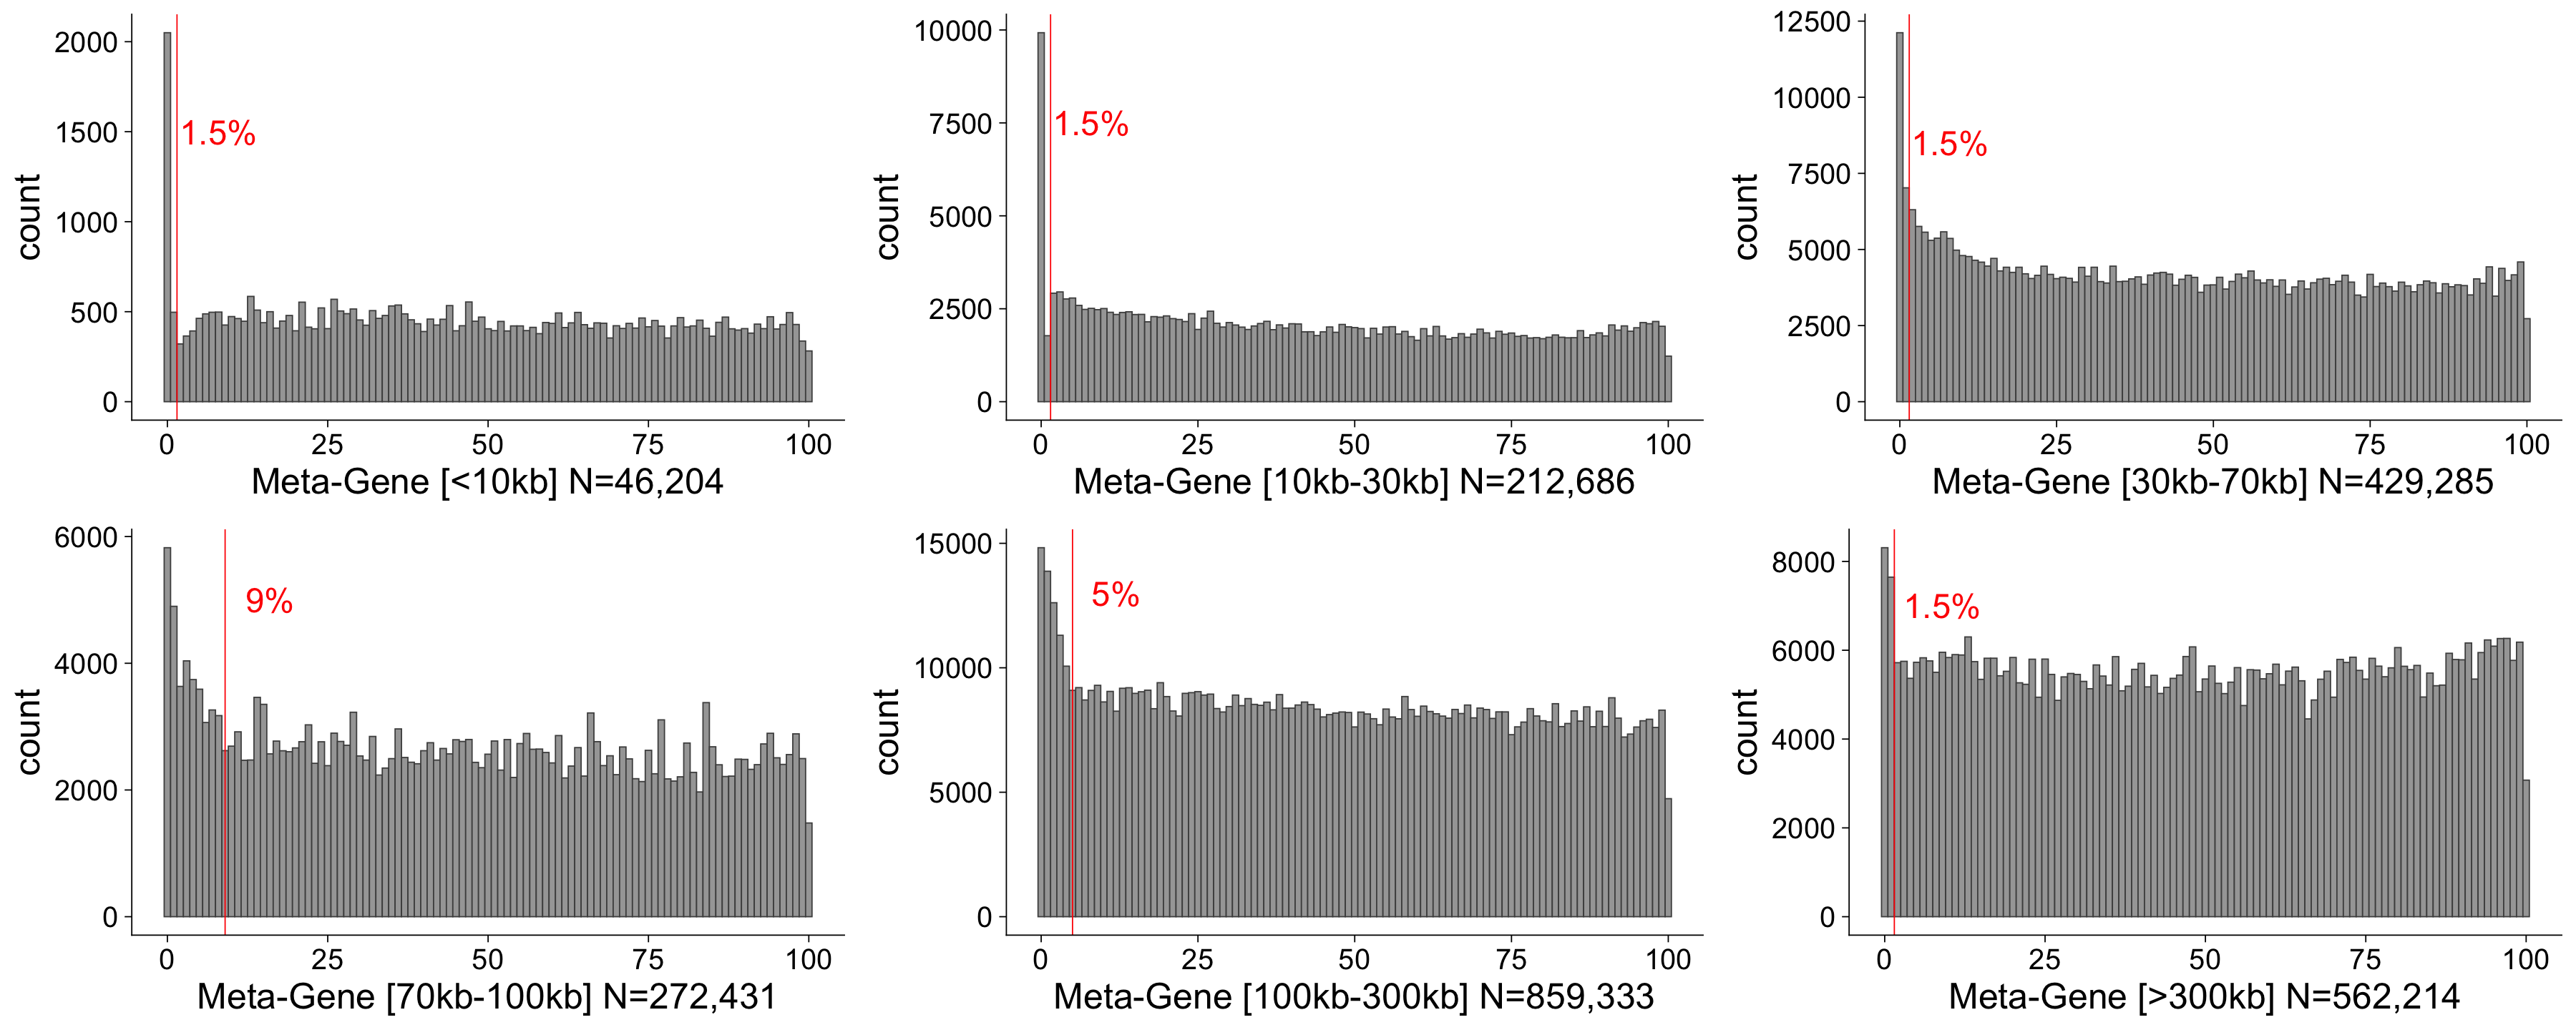

In [40]:
## FOR HG38 (annotation numbers)
use = hg38_overlaps[hg38_overlaps$Norm_Bid_mid >= 0 & hg38_overlaps$Norm_Bid_mid <= 100.5,]
graphing <- use[use$Ref_Gene_end<10000]
print("HG38 Bidirectional Midpoint Normalized to Gene")
p1 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=1.5, color="red") + annotate("text", x=8, y=1500, label="1.5%", color="red", size=10) +
 labs(x=paste0("Meta-Gene [<10kb] N=", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="count") + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")

graphing <- use[use$Ref_Gene_end>=10000 & use$Ref_Gene_end<30000]
p2 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=1.5, color="red") + annotate("text", x=8, y=7500, label="1.5%", color="red", size=10) +
labs(x=paste0("Meta-Gene [10kb-30kb] N=", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="count") + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")

graphing <- use[use$Ref_Gene_end>=30000 & use$Ref_Gene_end<70000]
p3 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=1.5, color="red") + annotate("text", x=8, y=8500, label="1.5%", color="red", size=10) +
labs(x=paste0("Meta-Gene [30kb-70kb] N=", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="count") + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")

graphing <- use[use$Ref_Gene_end>=70000 & use$Ref_Gene_end<100000]
p4 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=9, color="red") + annotate("text", x=16, y=5000, label="9%", color="red", size=10) +
 labs(x=paste0("Meta-Gene [70kb-100kb] N=", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="count") +  
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")

graphing <- use[use$Ref_Gene_end>=100000 & use$Ref_Gene_end<300000]
p5 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=5, color="red") + annotate("text", x=12, y=13000, label="5%", color="red", size=10) +
 labs(x=paste0("Meta-Gene [100kb-300kb] N=", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="count") +  
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")

graphing <- use[use$Ref_Gene_end>=300000]
p6 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=1.5, color="red") + annotate("text", x=9, y=7000, label="1.5%", color="red", size=10) +
labs(x=paste0("Meta-Gene [>300kb] N=", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="count") +  
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")
options(repr.plot.height = 12, repr.plot.width =30 )
save <- plot_grid(p1, p2, p3, p4, p5, p6, nrow=2)
save
# ggsave(save, width = 30, height = 12,
#        filename = paste0("./paper_figures/", genome, "_Norm_Bid_mid_histogram_genelengthbins.pdf"), 
#        bg = "transparent")
#save_image_png(save, "./paper_figures/Norm_Bid_mid_histogram_genelengthbins.png", width=25, height=8)

[1] "HG38 Bidirectional Midpoint Normalized to Gene"


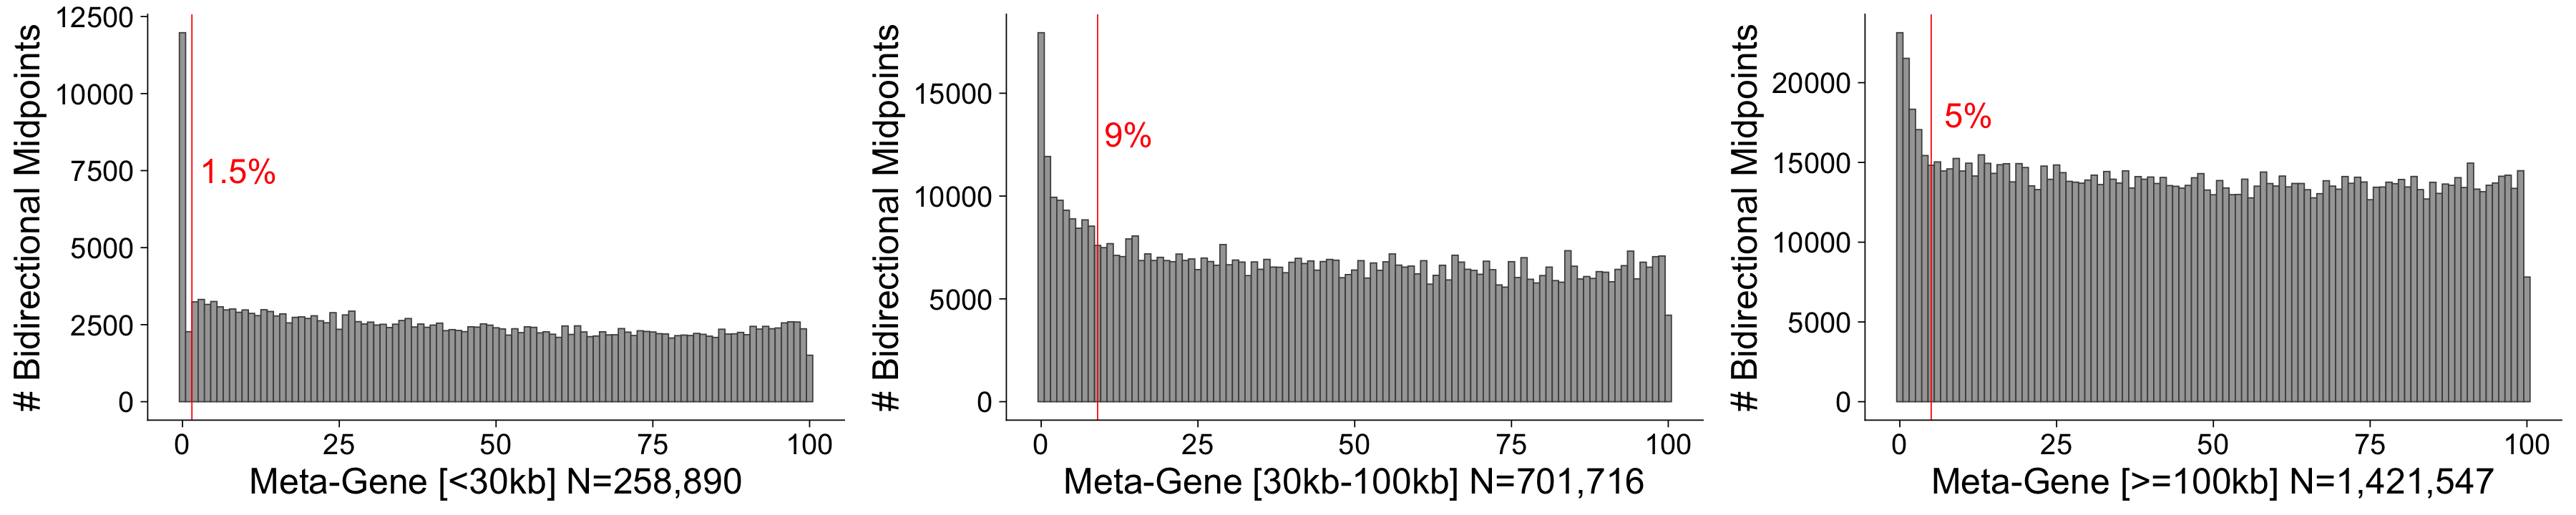

In [41]:
## FOR HG38 (annotation numbers)
graphing <- use[use$Ref_Gene_end<30000]
print("HG38 Bidirectional Midpoint Normalized to Gene")
p1 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=1.5, color="red") + annotate("text", x=9, y=7500, label="1.5%", color="red", size=10) +
 labs(x=paste0("Meta-Gene [<30kb] N=", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="# Bidirectional Midpoints") + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")


graphing <- use[use$Ref_Gene_end>=30000 & use$Ref_Gene_end<100000]
p3 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=9, color="red") + annotate("text", x=14, y=13000, label="9%", color="red", size=10) +
labs(x=paste0("Meta-Gene [30kb-100kb] N=", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="# Bidirectional Midpoints") + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")


graphing <- use[use$Ref_Gene_end>=100000,]
p5 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=5, color="red") + annotate("text", x=11, y=18000, label="5%", color="red", size=10) +
 labs(x=paste0("Meta-Gene [>=100kb] N=", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="# Bidirectional Midpoints") +  
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")
options(repr.plot.height = 6, repr.plot.width =30 )
save <- plot_grid(p1,  p3, p5, nrow=1)
save
ggsave(save, width = 30, height = 6,
       filename = paste0("./paper_figures/", genome, "_Norm_Bid_mid_histogram_3genelengthbins.png"), 
       bg = "transparent")
#save_image_png(save, "./paper_figures/Norm_Bid_mid_histogram_genelengthbins.png", width=25, height=8)

[1] "Bidirectional Midpoint Normalized to Gene"


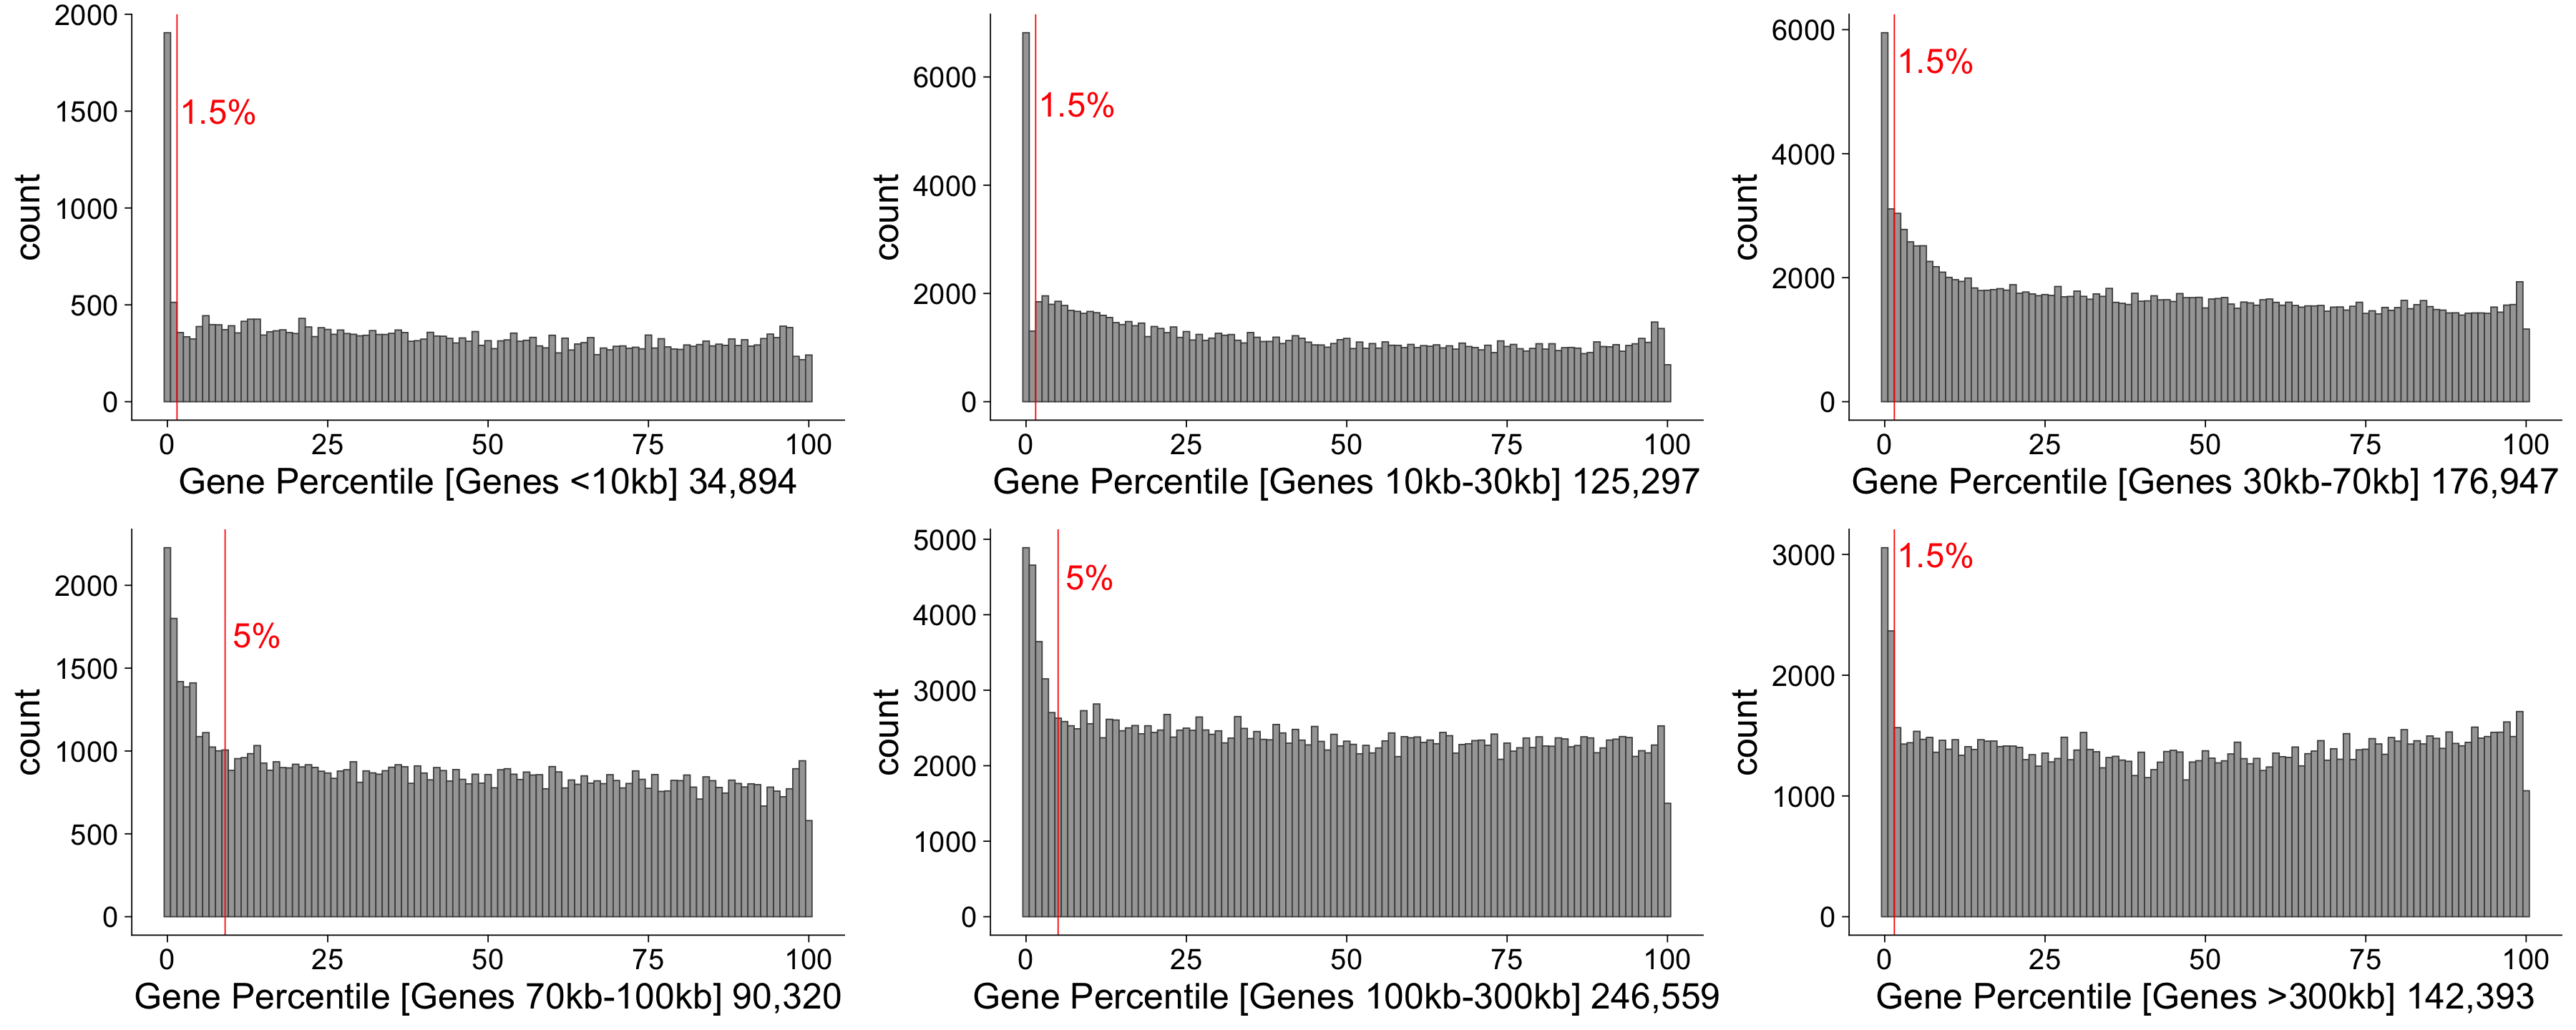

In [23]:
## FOR MM10 (annotation numbers)
graphing <- use[use$Ref_Gene_end<10000]
print("Bidirectional Midpoint Normalized to Gene")
p1 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=1.5, color="red") + annotate("text", x=8, y=1500, label="1.5%", color="red", size=10) +
 labs(x=paste("Gene Percentile [Genes <10kb]", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="count") + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")

graphing <- use[use$Ref_Gene_end>=10000 & use$Ref_Gene_end<30000]
p2 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=1.5, color="red") + annotate("text", x=8, y=5500, label="1.5%", color="red", size=10) +
labs(x=paste("Gene Percentile [Genes 10kb-30kb]", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="count") + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")

graphing <- use[use$Ref_Gene_end>=30000 & use$Ref_Gene_end<70000]
p3 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=1.5, color="red") + annotate("text", x=8, y=5500, label="1.5%", color="red", size=10) +
labs(x=paste("Gene Percentile [Genes 30kb-70kb]", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="count") + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")

graphing <- use[use$Ref_Gene_end>=70000 & use$Ref_Gene_end<100000]
p4 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=9, color="red") + annotate("text", x=14, y=1700, label="5%", color="red", size=10) +
 labs(x=paste("Gene Percentile [Genes 70kb-100kb]", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="count") +  
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")

graphing <- use[use$Ref_Gene_end>=100000 & use$Ref_Gene_end<300000]
p5 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=5, color="red") + annotate("text", x=10, y=4500, label="5%", color="red", size=10) +
 labs(x=paste("Gene Percentile [Genes 100kb-300kb]", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="count") +  
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")

graphing <- use[use$Ref_Gene_end>=300000]
p6 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=1.5, color="red") + annotate("text", x=8, y=3000, label="1.5%", color="red", size=10) +
labs(x=paste("Gene Percentile [Genes >300kb]", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="count") +  
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")
options(repr.plot.height = 12, repr.plot.width =30 )
save <- plot_grid(p1, p2, p3, p4, p5, p6, nrow=2)
save
ggsave(save, width = 30, height = 12,
       filename = paste0("./paper_figures/", genome, "_Norm_Bid_mid_histogram_genelengthbins.pdf"), 
       bg = "transparent")
#save_image_png(save, "./paper_figures/Norm_Bid_mid_histogram_genelengthbins.png", width=25, height=8)

[1] "Bidirectional Midpoint Normalized to Gene"


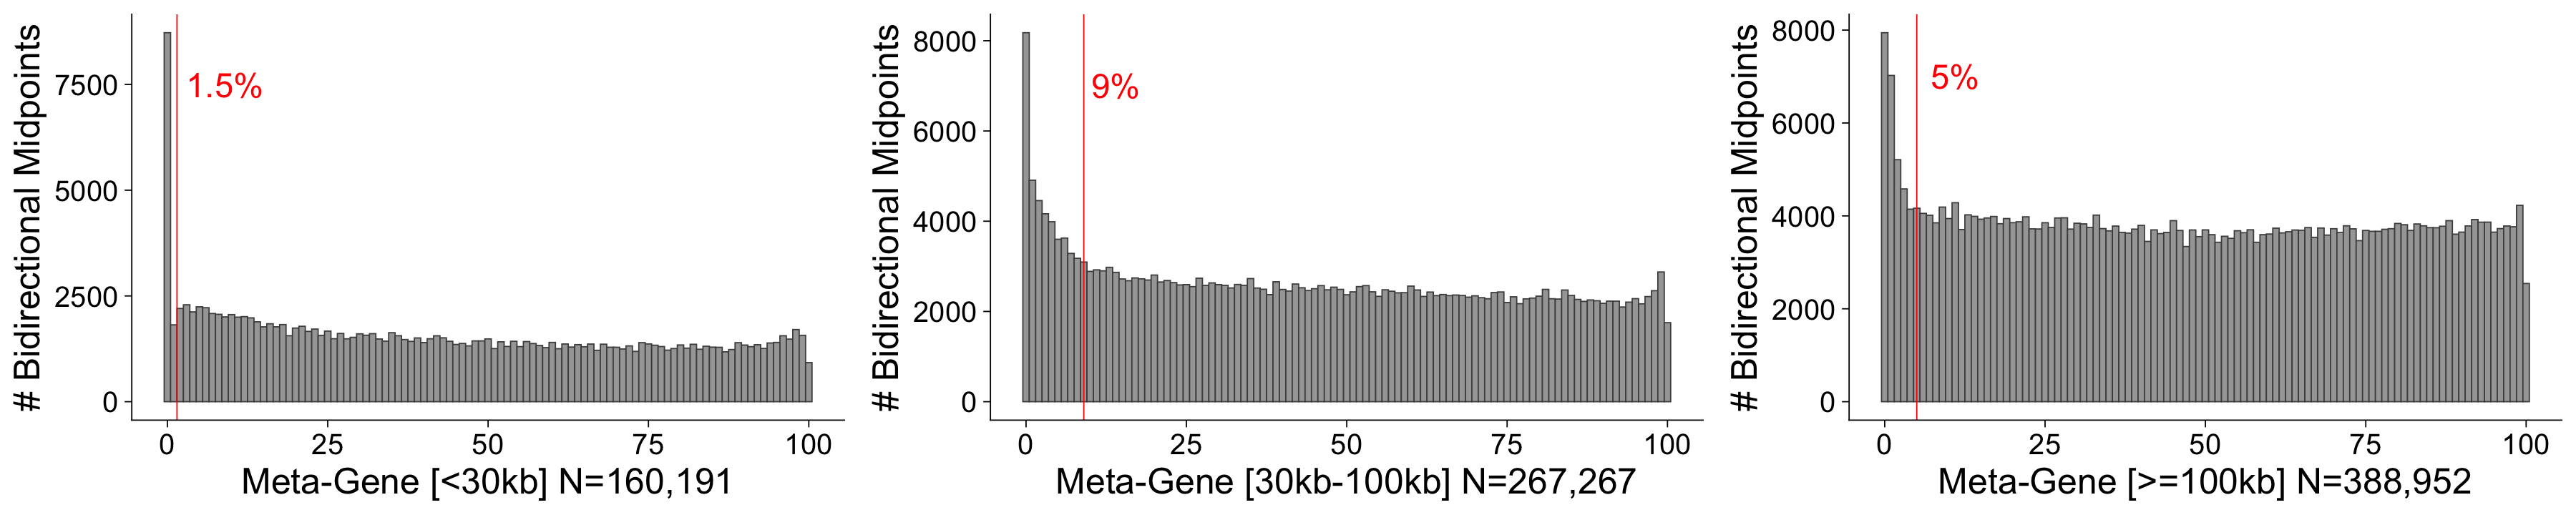

In [ ]:
## FOR MM10 (annotation numbers)
graphing <- use[use$Ref_Gene_end<30000]
print("Bidirectional Midpoint Normalized to Gene")
p1 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=1.5, color="red") + annotate("text", x=9, y=7500, label="1.5%", color="red", size=10) +
 labs(x=paste0("Meta-Gene [<30kb] N=", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="# Bidirectional Midpoints") + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")


graphing <- use[use$Ref_Gene_end>=30000 & use$Ref_Gene_end<100000]
p3 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=9, color="red") + annotate("text", x=14, y=7000, label="9%", color="red", size=10) +
labs(x=paste0("Meta-Gene [30kb-100kb] N=", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="# Bidirectional Midpoints") + 
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")


graphing <- use[use$Ref_Gene_end>=100000,]
p5 <- ggplot(graphing, aes(x=Norm_Bid_mid)) + 
geom_histogram(binwidth=1, color="grey30", fill=ru_color) + theme_cowplot(cowplot_theme) +
geom_vline(xintercept=5, color="red") + annotate("text", x=11, y=7000, label="5%", color="red", size=10) +
 labs(x=paste0("Meta-Gene [>=100kb] N=", format(nrow(graphing), scientific=FALSE, big.mark=',', size=8)), y="# Bidirectional Midpoints") +  
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 24),
     axis.text.x = element_text(size = 24),
     legend.position="none")
options(repr.plot.height = 6, repr.plot.width =30 )
save <- plot_grid(p1,  p3, p5, nrow=1)
save
ggsave(save, width = 30, height = 6,
       filename = paste0("./paper_figures/", genome, "_Norm_Bid_mid_histogram_3genelengthbins.png"), 
       bg = "transparent")
#save_image_png(save, "./paper_figures/Norm_Bid_mid_histogram_genelengthbins.png", width=25, height=8)